# Create COCO annotations and train Detectron2 Neural Network

After creating ~2000 tiles and use the segmentation on Apeer, transform the masks into single particle masks, create COCO annotations and train 


### Table of content

## Installation

- conda create --name coco1
- conda activate coco1


Add env to jupyter kernel: 

- conda install -c anaconda ipykernel
- python -m ipykernel install --user --name=coco1



xxx- conda install pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch xxx
xxx - pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

- conda install pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch

- git clone https://github.com/facebookresearch/detectron2.git
- python -m pip install -e detectron2

- pip install git+https://github.com/waspinator/pycococreator.git

- pip install tensorflow
- pip install matplotlib
- pip install opencv-python
- 


# Train Detectron2 NN from Apeer images and masks

Using Apeer solution as ground truth to finally have a reasonable amount of data. 

But first, we need annotations. It is impossible to train a NN directly from images.

A good read explains why COCO format is needed and how to convert masks to COCO [here](https://patrickwasp.com/create-your-own-coco-style-dataset/). More info on the [github](https://github.com/waspinator/pycococreator/).


### Structure needed: 

One directory with .jpg images (tiles) 

One directory with .tiff images, masks from Apeer. 

Rename the images and place them in a folder like the following: 

```

└── particles
    └── train
        ├── annotations
        │   │ <image_id>_<object_class_name>_<annotation_id>.png
        └── particles_train2022
        │   │   <image_id>.jpeg
```

**IMPORTANT:** the image_id and annotation_id shouldn't contain characters like "\_" or "-". This will cause problems with the split functions of pycococreator that need to be adapted. 

### Server Structure

Structure present on the server. For each new trial, the "particles" directory is renamed, and the current one remains named "particles". 

```
└── 1_IMPTOX 
    └── TransferLearning
        └── 0_data
            └── particles
                └── train
                    └── annotations : contains the .PNG masks
                    └── annotations_tiff : contains the tiff annotations from Apeer
                    └── particles_train2022 : contains the .jpg images matching the Annotation name as above
        
        └── 1_keras_detectron_convertion
            └── h5_pth_convertion.ipynb (this notebook)
            └── model.h5 : keras model from Apeer (useless, as seen above)

```

In [1]:
# FAILED
#!pip install git+git://github.com/waspinator/pycococreator.git@0.2.0
#!pip install git+git://github.com/waspinator/coco.git@2.1.0


# Downloaded manually and execute pip install. 


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import re
import cv2
from PIL import Image
import detectron2
import scipy.ndimage # fill holes
#model = keras.models.load_model('./model.h5')
#model.summary()

#  Pycococreator

### Generate coco annotations json file for the images. 

In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import datetime

INFO = {
    "description": "Particle Dataset",
    "url": "https://github.com/waspinator/pycococreator",
    "version": "0.1.0",
    "year": 2022,
    "contributor": "waspinator",
    "date_created": datetime.datetime.utcnow().isoformat(' ')
}

LICENSES = [
    {
        "id": 1,
        "name": "Attribution-NonCommercial-ShareAlike License",
        "url": "http://creativecommons.org/licenses/by-nc-sa/2.0/"
    }
]

CATEGORIES = [
    {
        'id': 1,
        'name': 'particle',
        'supercategory': 'particles',
    },
]

> Regex modified. Check issues on github. 

In [2]:

import datetime
import json
import os
import re
import fnmatch
from PIL import Image
import numpy as np
from pycococreatortools import pycococreatortools

In [3]:
BYPASS = True # don't do that twice, it takes time !



ROOT_DIR = '../0_data/CocoConvertion/particles/train'
IMAGE_DIR = os.path.join(ROOT_DIR, "particles_train2022")
ANNOTATION_DIR = os.path.join(ROOT_DIR, "annotations")



def filter_for_jpeg(root, files):
    file_types = ['*.jpeg', '*.jpg']
    file_types = r'|'.join([fnmatch.translate(x) for x in file_types])
    files = [os.path.join(root, f) for f in files]
    files = [f for f in files if re.match(file_types, f)]
    
    return files


# BE CAREFULL WITH THIS ANNOYING FUNCTION
def filter_for_annotations(root, files, image_filename):
    file_types = ['*.PNG']
    file_types = r'|'.join([fnmatch.translate(x) for x in file_types])
    
    basename_no_extension = os.path.splitext(os.path.basename(image_filename))[0]
    
    file_name_prefix = basename_no_extension + '_.*'
    
    files = [os.path.join(root, f) for f in files] # List of all annotation files (with path)
    
    print(f"Filter annot prefix: {file_name_prefix}")
        
    # Add annotation files to the list (one only should match)
    files = [f for f in files if re.match(file_name_prefix, os.path.splitext(os.path.basename(f))[0])]

    return files

def main():

    coco_output = {
        "info": INFO,
        "licenses": LICENSES,
        "categories": CATEGORIES,
        "images": [],
        "annotations": []
    }

    image_id = 1
    segmentation_id = 1
    
    # filter for jpeg images
    for root, _, files in os.walk(IMAGE_DIR):
        image_files = filter_for_jpeg(root, files)
        
        # go through each image
        for image_filename in image_files:
            image = Image.open(image_filename)
            image_info = pycococreatortools.create_image_info(
                image_id, os.path.basename(image_filename), image.size)
            coco_output["images"].append(image_info)
            print(f"Image {image_filename}")

            # filter for associated png annotations
            for root, _, files in os.walk(ANNOTATION_DIR):
                annotation_files = filter_for_annotations(root, files, image_filename) # PROBLEM HERE - Too Much Files
                #print(f"Annotation files: {annotation_files}")

                # go through each associated annotation
                for annotation_filename in annotation_files:
                    
                    #print(f"Annotation filename: {annotation_filename}")
                    #class_id = [x['id'] for x in CATEGORIES if x['name'] in annotation_filename][0]
                    class_id = [x['id'] for x in CATEGORIES if x['name'] in annotation_filename][0]

                    category_info = {'id': class_id, 'is_crowd': 'crowd' in image_filename}
                    #category_info = {'id': class_id, 'is_crowd': 1} 
                    # Is Crowd means: don't train on it. Use semantic segmentation instead of instance.
                    
                    binary_mask = np.asarray(Image.open(annotation_filename).convert('1')).astype(np.uint8)
                    
                    
                    annotation_info = pycococreatortools.create_annotation_info(
                        segmentation_id, image_id, category_info, binary_mask,
                        image.size, tolerance=2)

                    if annotation_info is not None:
                        coco_output["annotations"].append(annotation_info)
                        #print("...........Adding annotation..............")
                        #print(annotation_info['image_id'])
                        #print("..........................................")

                    segmentation_id = segmentation_id + 1

            image_id = image_id + 1

    with open('{}/instances_particles_train2022.json'.format(ROOT_DIR), 'w') as output_json_file:
        json.dump(coco_output, output_json_file)
    return(coco_output)


if __name__ == "__main__":
    
    
    ### Test filter functions
    #for root, _, files in os.walk(IMAGE_DIR):
    #    image_files = filter_for_jpeg(root, files)
    #    for image_filename in [image_files[0]]:
    #        for root, _, files in os.walk(ANNOTATION_DIR):
    #            annotation_files = filter_for_annotations(root, files, image_filename)
    #            for annotation_filename in annotation_files:
    #                print(f"Annotation filename: {annotation_filename}")
    ### ----------------------------
    
    if(not BYPASS):
        print("Convert binary masks to coco annotations.")
        coco_output = main()
        print("Done!")
    else:
        print("Bypassing coco annotation creation.")

Bypassing coco annotation creation.


In [7]:
f = open("../0_data/CocoConvertion/particles/train/instances_particles_train2022.json")

coco_output = json.load(f)

In [8]:
coco_output.keys()

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])

In [9]:
coco_output['info']

{'description': 'Particle Dataset',
 'url': 'https://github.com/waspinator/pycococreator',
 'version': '0.1.0',
 'year': 2022,
 'contributor': 'waspinator',
 'date_created': '2022-06-16 07:30:05.379571'}

In [10]:
coco_output['categories']
# coco_output['annotations']

[{'id': 1, 'name': 'particle', 'supercategory': 'particles'}]

## Visualize the dataset

In [11]:
# https://github.com/waspinator/pycococreator/blob/master/examples/shapes/visualize_coco.ipynb

%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

image_directory = '../0_data/CocoConvertion/particles/train/particles_train2022/'
annotation_file = '../0_data/CocoConvertion/particles/train/instances_particles_train2022.json'

example_coco = COCO(annotation_file)

loading annotations into memory...
Done (t=1.66s)
creating index...
index created!


In [12]:
categories = example_coco.loadCats(example_coco.getCatIds())
category_names = [category['name'] for category in categories]
print('Custom COCO categories: \n{}\n'.format(' '.join(category_names)))

category_names = set([category['supercategory'] for category in categories])
print('Custom COCO supercategories: \n{}'.format(' '.join(category_names)))

category_ids = example_coco.getCatIds(catNms=['particle'])#square
image_ids = example_coco.getImgIds(catIds=category_ids)

print(f"Image ids: {image_ids}")

Custom COCO categories: 
particle

Custom COCO supercategories: 
particles
Image ids: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 2

In [13]:
# Select a random id to show the image and annotations

random_id = np.random.randint(0, len(image_ids))

image_data = example_coco.loadImgs(image_ids[random_id])[0]
print(image_data)



{'id': 2080, 'file_name': '2x54.jpg', 'width': 752, 'height': 480, 'date_captured': '2022-06-16 06:42:19.828275', 'license': 1, 'coco_url': '', 'flickr_url': ''}


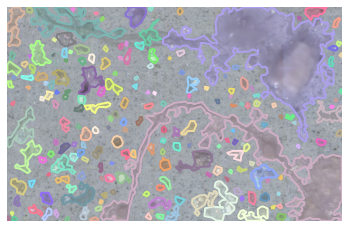

In [14]:
# load and display instance annotations
image = io.imread(image_directory + image_data['file_name'])

plt.imshow(image); plt.axis('off')
pylab.rcParams['figure.figsize'] = (15.0, 20.0)
annotation_ids = example_coco.getAnnIds(imgIds=image_data['id'], catIds=category_ids, iscrowd=None)
annotations = example_coco.loadAnns(annotation_ids)
example_coco.showAnns(annotations)

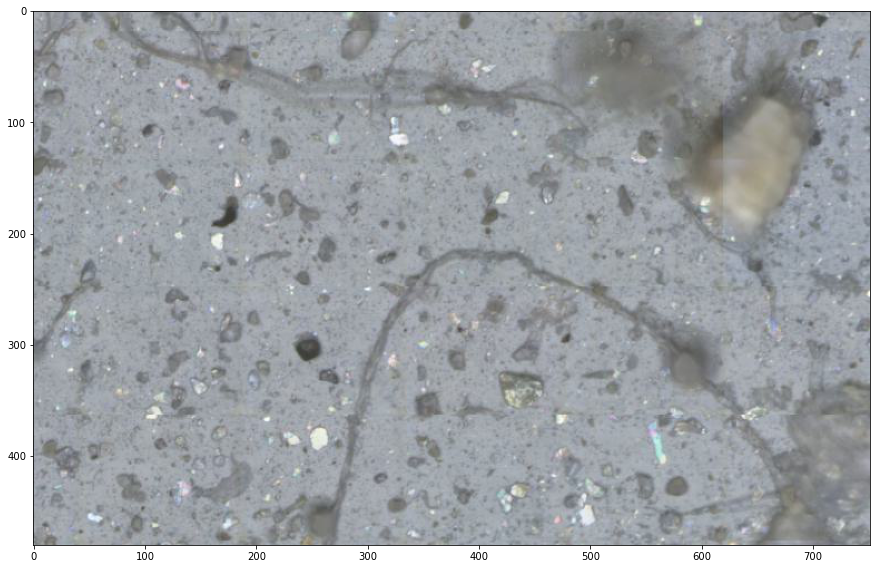

In [15]:
# display images
fig, ax = plt.subplots(1,1)
ax.imshow(image)
plt.show()

#### For a few annotations, show the image overlay

loading annotations into memory...
Done (t=2.08s)
creating index...
index created!

Custom COCO categories: 
particle


Custom COCO supercategories: 
particles

Image ids: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 

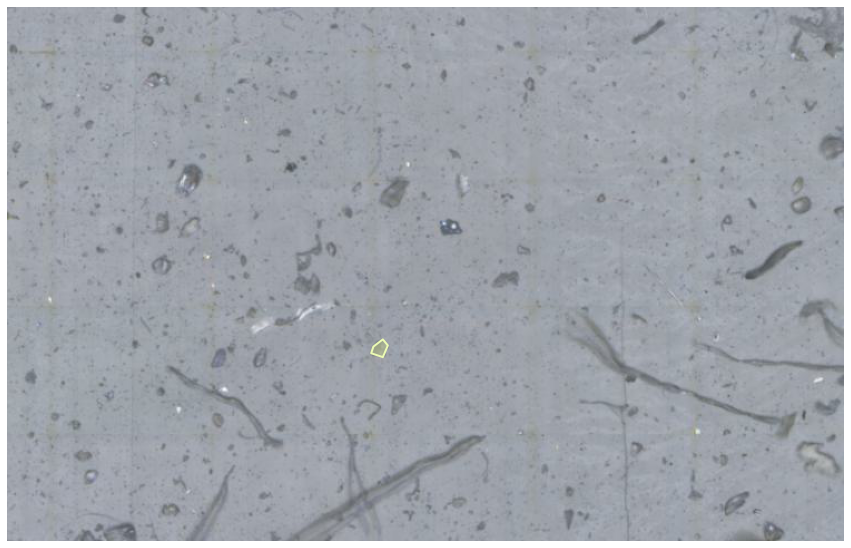


Image data: {'id': 2, 'file_name': '10x50xflip.jpg', 'width': 752, 'height': 480, 'date_captured': '2022-06-16 06:42:19.828275', 'license': 1, 'coco_url': '', 'flickr_url': ''}
Length annotation 1


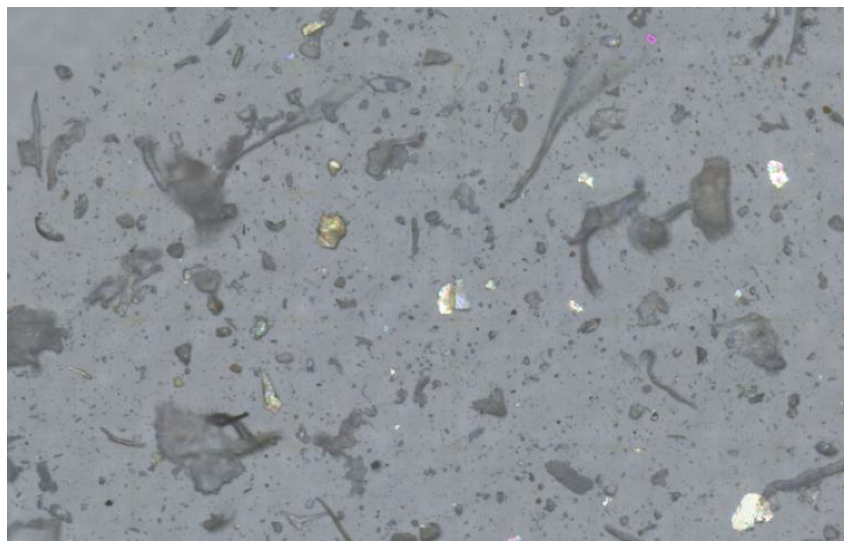


Image data: {'id': 3, 'file_name': '11x47xmirror.jpg', 'width': 752, 'height': 480, 'date_captured': '2022-06-16 06:42:19.828275', 'license': 1, 'coco_url': '', 'flickr_url': ''}
Length annotation 1


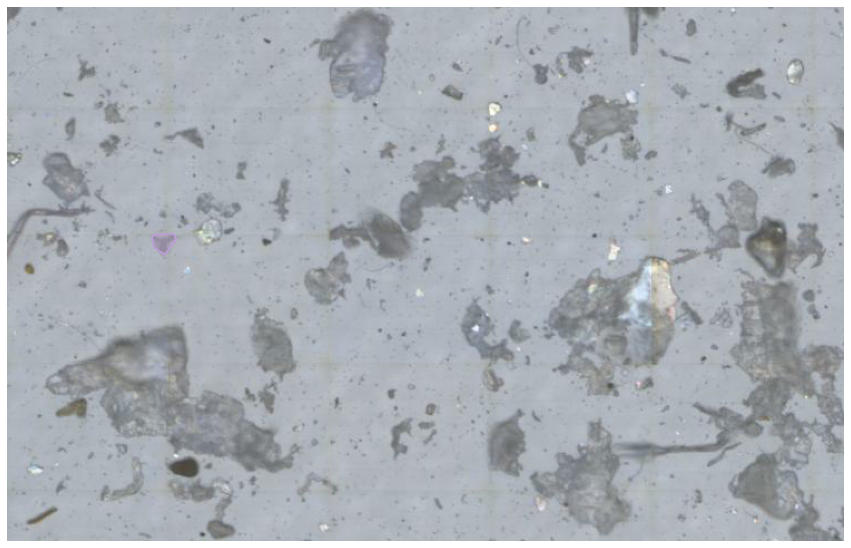


Image data: {'id': 4, 'file_name': '11x42.jpg', 'width': 752, 'height': 480, 'date_captured': '2022-06-16 06:42:19.828275', 'license': 1, 'coco_url': '', 'flickr_url': ''}
Length annotation 1


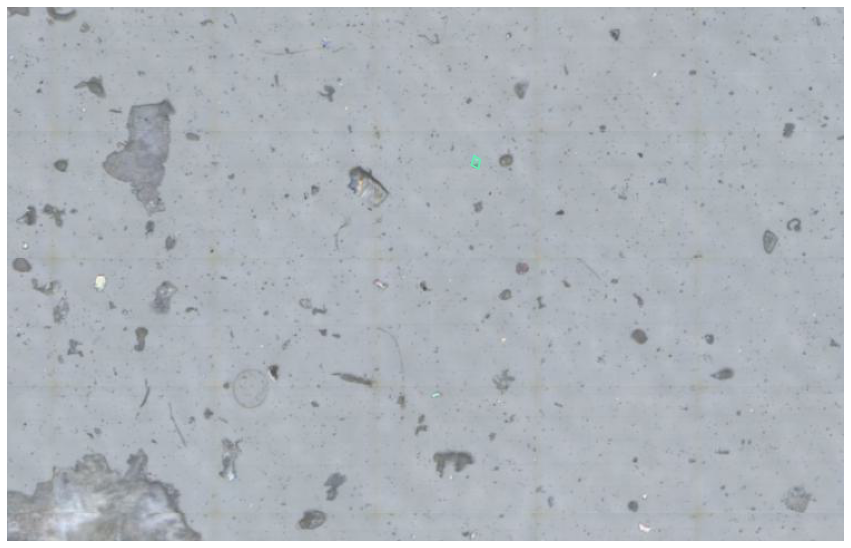


Image data: {'id': 5, 'file_name': '7x41xflip.jpg', 'width': 752, 'height': 480, 'date_captured': '2022-06-16 06:42:19.828275', 'license': 1, 'coco_url': '', 'flickr_url': ''}
Length annotation 1


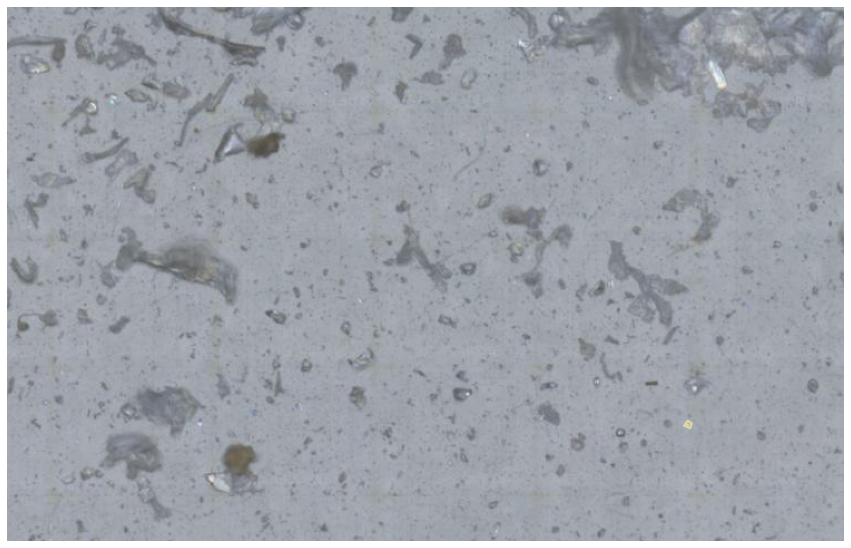


Image data: {'id': 6, 'file_name': '8x18xflip.jpg', 'width': 752, 'height': 480, 'date_captured': '2022-06-16 06:42:19.828275', 'license': 1, 'coco_url': '', 'flickr_url': ''}
Length annotation 1


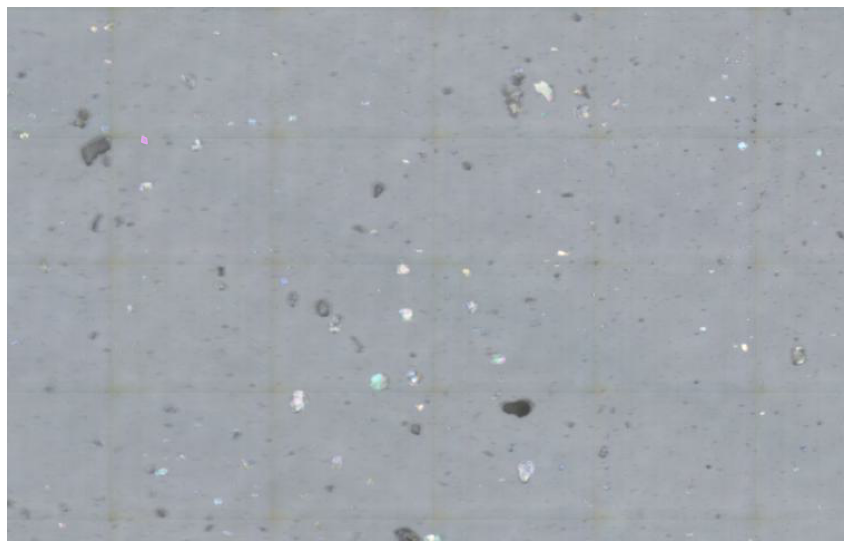


Image data: {'id': 7, 'file_name': '7x27xflip.jpg', 'width': 752, 'height': 480, 'date_captured': '2022-06-16 06:42:19.828275', 'license': 1, 'coco_url': '', 'flickr_url': ''}
Length annotation 1


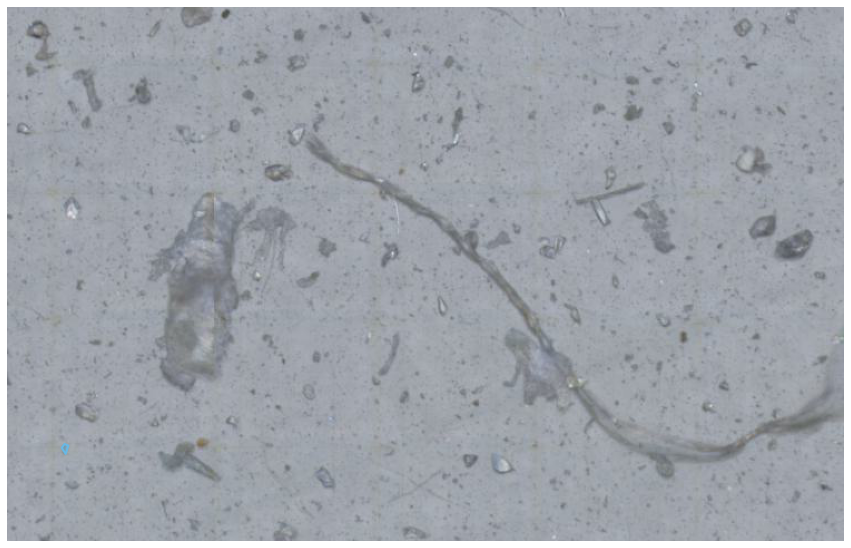


Image data: {'id': 8, 'file_name': '4x72.jpg', 'width': 752, 'height': 480, 'date_captured': '2022-06-16 06:42:19.828275', 'license': 1, 'coco_url': '', 'flickr_url': ''}
Length annotation 1


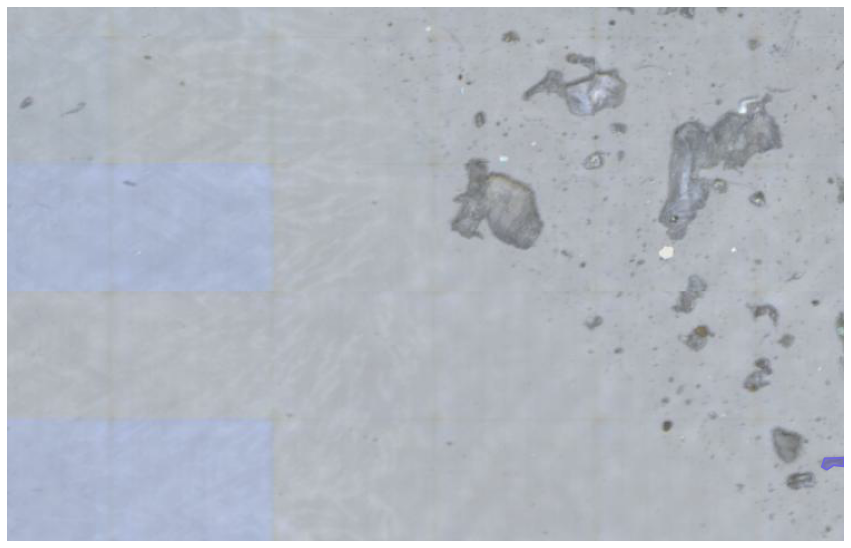


Image data: {'id': 9, 'file_name': '10x15.jpg', 'width': 752, 'height': 480, 'date_captured': '2022-06-16 06:42:19.828275', 'license': 1, 'coco_url': '', 'flickr_url': ''}
Length annotation 1


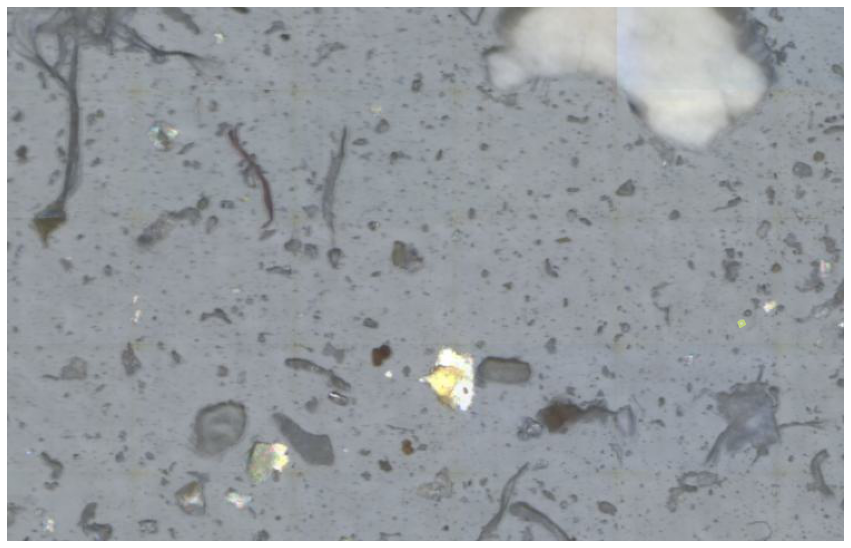


Image data: {'id': 10, 'file_name': '9x41.jpg', 'width': 752, 'height': 480, 'date_captured': '2022-06-16 06:42:19.828275', 'license': 1, 'coco_url': '', 'flickr_url': ''}
Length annotation 1


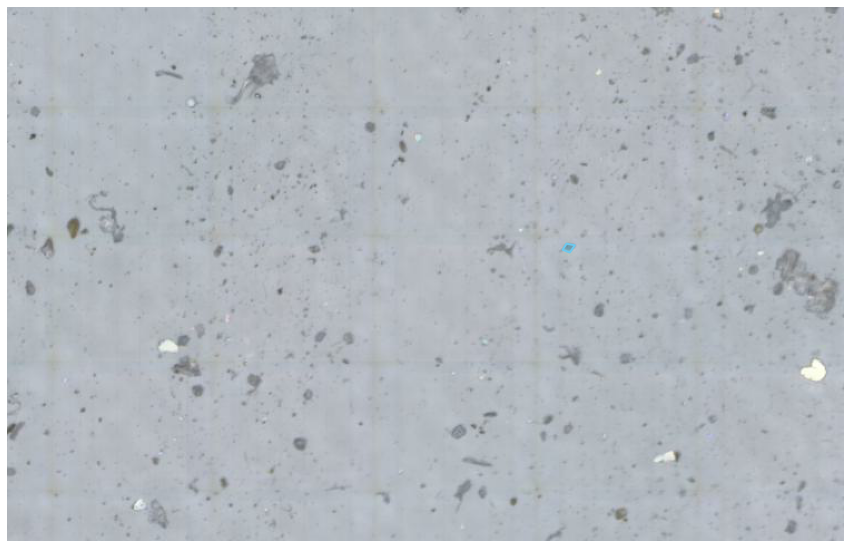

In [16]:


image_directory = '../0_data/CocoConvertion/particles/train/particles_train2022/'
annotation_file = '../0_data/CocoConvertion/particles/train/instances_particles_train2022.json'

example_coco = COCO(annotation_file)

categories = example_coco.loadCats(example_coco.getCatIds())
category_names = [category['name'] for category in categories]
print('\nCustom COCO categories: \n{}\n'.format(' '.join(category_names)))

supercategory_names = set([category['supercategory'] for category in categories])
print('\nCustom COCO supercategories: \n{}'.format(' '.join(supercategory_names)))

category_ids = example_coco.getCatIds(catNms=['particle'])#square
image_ids = example_coco.getImgIds(catIds=category_ids)

print(f"\nImage ids: {image_ids}")


for img_id in range(len(image_ids)):
    
    # Just a sample
    if img_id == 10:
        break
        
    # Load image data
    image_data = example_coco.loadImgs(image_ids[img_id])[0]
    print(f"\nImage data: {image_data}")
    
    # load and display instance annotations
    image = io.imread(image_directory + image_data['file_name'])
    
    plt.imshow(image); plt.axis('off')
    pylab.rcParams['figure.figsize'] = (15.0, 20.0)
    annotation_ids = example_coco.getAnnIds(imgIds=image_data['id'], catIds=category_ids)
    annotations = example_coco.loadAnns(annotation_ids)
    annotations = [annotations[0]]
    
    print(f"Length annotation {len(annotations)}")
    example_coco.showAnns(annotations)
    plt.show()

#for i in range(len(annotations)):
#    print(annotations[i]["image_id"])
#    mask_ = example_coco.annToMask(annotations[i])
#    plt.imshow(mask_)
#    plt.show()
    

#### Train Detectron2 with our images and coco annotations


https://medium.com/@chengweizhang2012/how-to-train-detectron2-with-custom-coco-datasets-4d5170c9f389




In [17]:
# just run those 4 lines to install the latest Pytorch 1.3 and Detectron2.
#!pip install -U torch torchvision
#!pip install git+https://github.com/facebookresearch/fvcore.git
#!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
#!pip install -e detectron2_repo

### Register the dataset using Detectron2 tutorial

Use tile dataset only (right resolution for .pth used with Labelbox) 

https://github.com/facebookresearch/detectron2/blob/main/docs/tutorials/datasets.md



In [17]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog
DatasetCatalog.clear()

In [18]:


register_coco_instances("particles", {}, 
                        "../0_data/CocoConvertion/particles/train/instances_particles_train2022.json", 
                        "../0_data/CocoConvertion/particles/train/particles_train2022/")

[10/11 13:51:01 d2.data.datasets.coco]: Loading ../0_data/CocoConvertion/particles/train/instances_particles_train2022.json takes 1.67 seconds.
[10/11 13:51:01 d2.data.datasets.coco]: Loaded 2454 images in COCO format from ../0_data/CocoConvertion/particles/train/instances_particles_train2022.json


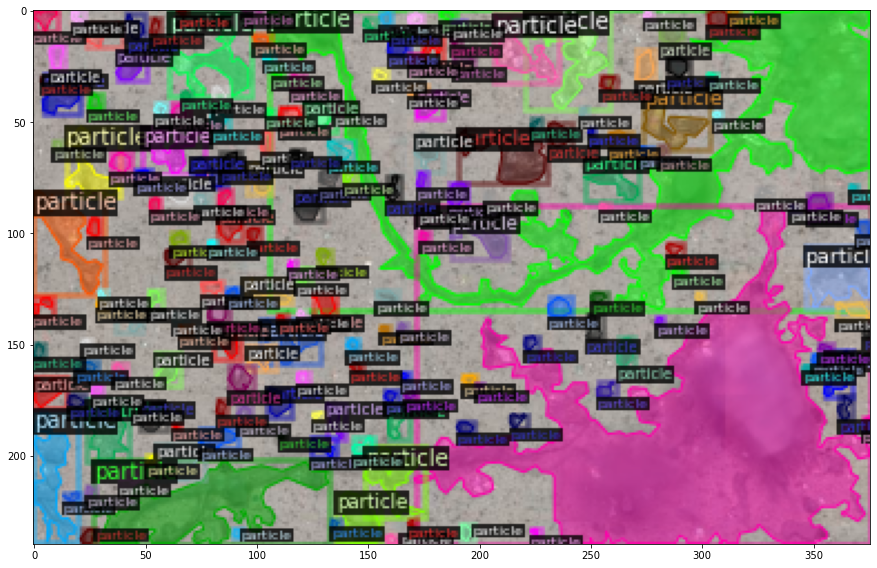

In [19]:
import random

import cv2

from detectron2.utils.visualizer import Visualizer
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

dataset_dicts = DatasetCatalog.get("particles")
particles_metadata = MetadataCatalog.get("particles")

for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=particles_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

### Train Detectron2 with tiles and

Fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the particles dataset.

In [21]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.OUTPUT_DIR = "./TrainDetectron2Model"
cfg.merge_from_file(
    #"../../Other/detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
    "../../Other/detectron2/configs/Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml"
) # Detectron2 accidentally installed at more than one place
cfg.DATASETS.TRAIN = ("particles",)
cfg.DATASETS.TEST = ()  # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.MODEL.DEVICE = 'cuda'  # cpu or cuda
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 0.008
cfg.SOLVER.MAX_ITER = (
    3000
)  # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = (
    512
)  # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # 1 class: particle

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

#

[10/11 13:52:50 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.bias' to the model due to incompatible shapes: (80,) in the checkpoint but (1,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_head.0.fc1.{bias, weight}
roi_heads.box_head.0.fc2.{bias, weight}
roi_heads.box_head.1.fc1.{bias, weight}
roi_heads.box_head.1.fc2.{bias, weight}
roi_heads.box_head.2.fc1.{bias, weight}
roi_heads.box_head.2.fc2.{bias, weight}
roi_heads.box_predictor.0.bbox_pred.{bias, weight}
roi_heads.box_predictor.0.cls_score.{bias, weight}
roi_heads.box_predictor.1.bbox_pred.{bias, weight}
roi_heads.box_predictor.1.cls_score.{bias, weight}
roi_heads.box_predictor.2.bbox_pred.{bias, weight}
roi_heads.box_pre

[10/11 13:52:59 d2.engine.train_loop]: Starting training from iteration 0


/home/thibault.schowing/miniconda3/envs/allpurpose/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[10/11 13:53:06 d2.utils.events]:  eta: 0:16:40  iter: 19  total_loss: 4.887  loss_cls_stage0: 0.5745  loss_box_reg_stage0: 0.5788  loss_cls_stage1: 0.5721  loss_box_reg_stage1: 0.5509  loss_cls_stage2: 0.5397  loss_box_reg_stage2: 0.2913  loss_mask: 0.6841  loss_rpn_cls: 0.8101  loss_rpn_loc: 0.2929  time: 0.3367  data_time: 0.0156  lr: 0.00015985  max_mem: 3064M
[10/11 13:53:12 d2.utils.events]:  eta: 0:16:24  iter: 39  total_loss: 3.834  loss_cls_stage0: 0.4501  loss_box_reg_stage0: 0.5752  loss_cls_stage1: 0.3872  loss_box_reg_stage1: 0.5402  loss_cls_stage2: 0.3227  loss_box_reg_stage2: 0.3273  loss_mask: 0.5812  loss_rpn_cls: 0.2819  loss_rpn_loc: 0.2269  time: 0.3341  data_time: 0.0020  lr: 0.00031969  max_mem: 3064M
[10/11 13:53:19 d2.utils.events]:  eta: 0:16:26  iter: 59  total_loss: 3.435  loss_cls_stage0: 0.336  loss_box_reg_stage0: 0.6119  loss_cls_stage1: 0.2952  loss_box_reg_stage1: 0.6683  loss_cls_stage2: 0.2523  loss_box_reg_stage2: 0.4174  loss_mask: 0.433  loss_rpn_

Make a prediction
Now, we perform inference with the trained model on the particles dataset. First, let’s create a predictor using the model we just trained:

In [23]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3   # set the testing threshold for this model
cfg.DATASETS.TEST = ("particles", )
cfg.TEST.DETECTIONS_PER_IMAGE = 2000
predictor = DefaultPredictor(cfg)

[10/11 14:16:46 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

Then, we randomly select several samples to visualize the prediction results.

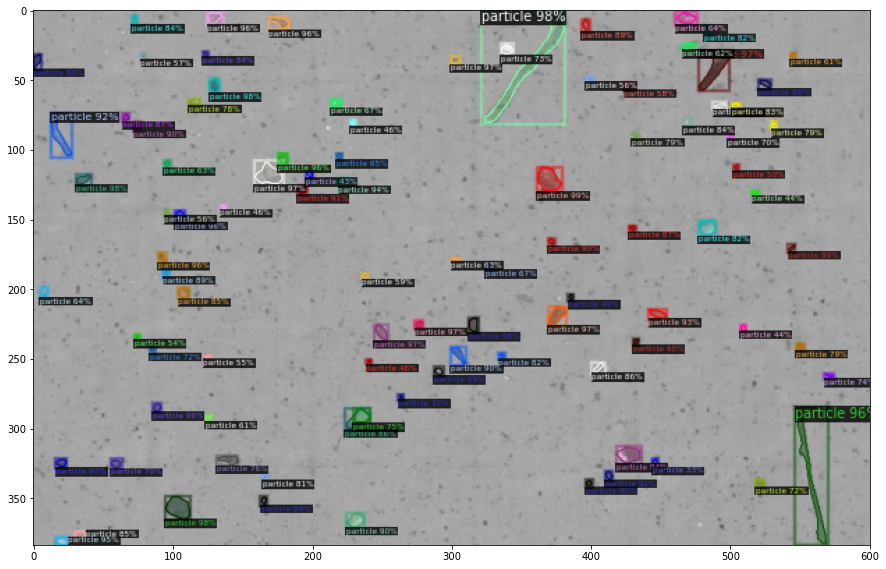

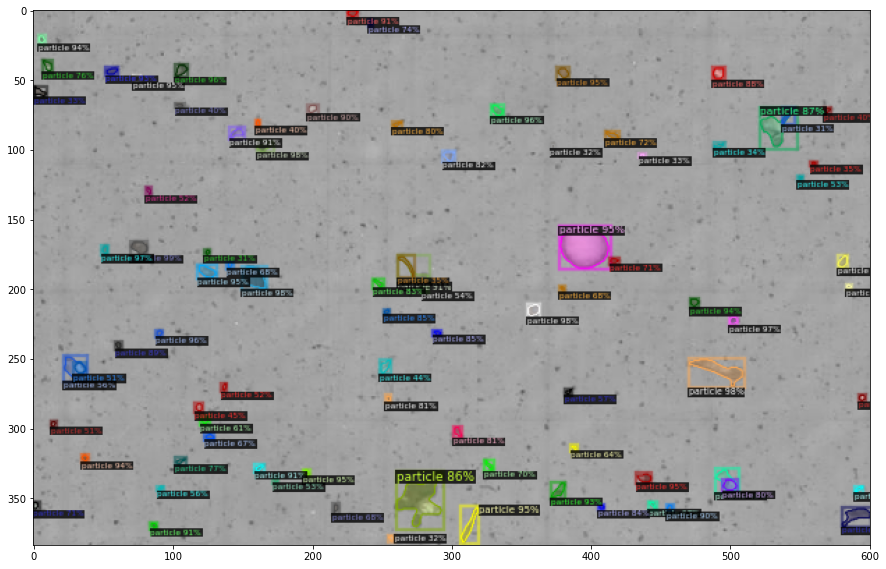

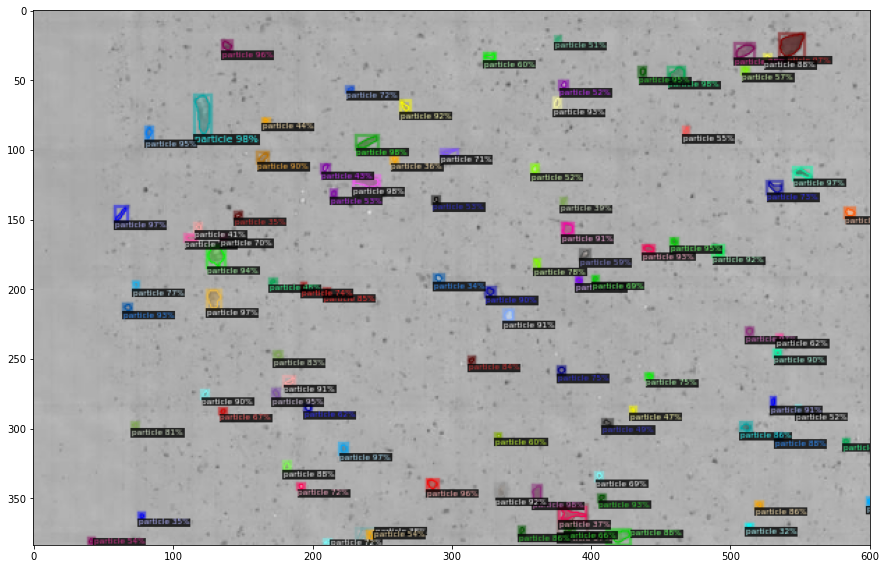

In [24]:
from detectron2.utils.visualizer import ColorMode
import PIL

for d in random.sample(dataset_dicts, 3):    
    img = cv2.imread(d["file_name"])
    
    # Test augment brightness and contrast
    # https://stackoverflow.com/questions/50474302/how-do-i-adjust-brightness-contrast-and-vibrance-with-opencv-python
    #brightness = -10
    #contrast = 127
    #img = np.int16(img)
    #img = img * (contrast/127+1) - contrast + brightness
    #img = np.clip(img, 0, 255)
    #img = np.uint8(img)
    
    # ------
    #image = PIL.Image.open(d["file_name"])

    #img = np.array(PIL.ImageEnhance.Contrast(image).enhance(1.2))
    
    
    # 
    
    
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1],
                   metadata=particles_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    
    
    
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.show()

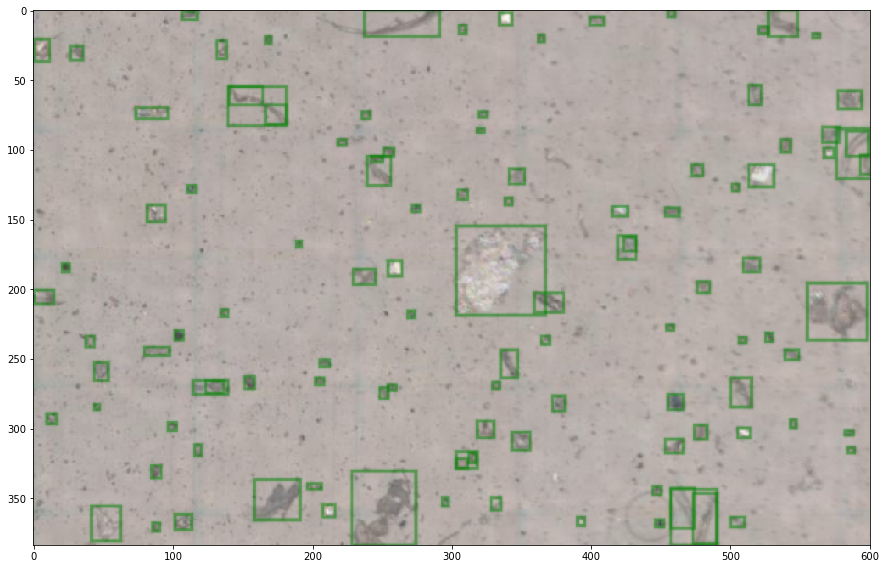

In [25]:
for d in random.sample(dataset_dicts, 1):    
    img = cv2.imread(d["file_name"])
    plt.imshow(img)
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1],
                   metadata=particles_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    for box in outputs["instances"].pred_boxes.to('cpu'):
        v.draw_box(box)
        #v.draw_text(str(box[:2].numpy()), tuple(box[:2].numpy()))
    v = v.get_output()
    img =  v.get_image()[:, :, ::-1]
    plt.imshow(img)
    

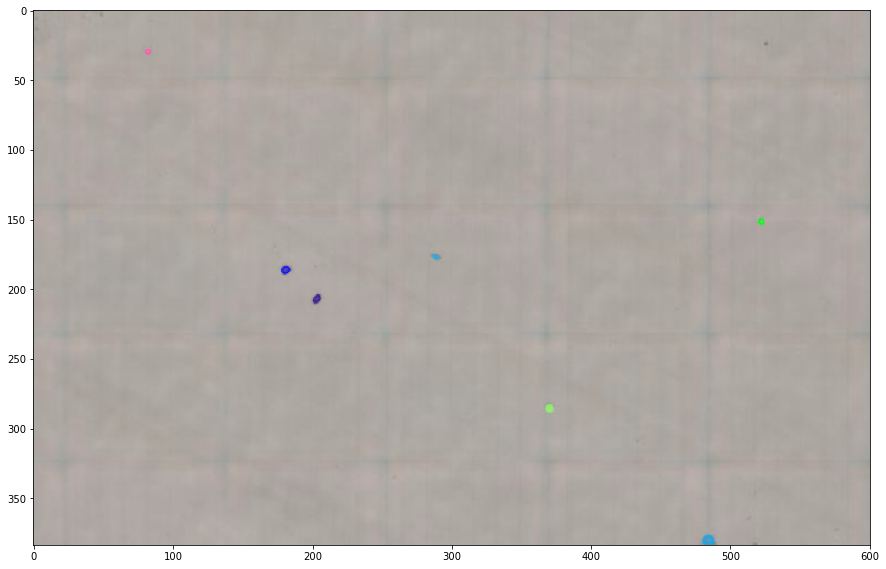

In [26]:
for d in random.sample(dataset_dicts, 1):    
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1],
                   metadata=particles_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    for m in outputs["instances"].get("pred_masks").to('cpu').numpy():
        v.draw_binary_mask(m)
        #v.draw_text(str(box[:2].numpy()), tuple(box[:2].numpy()))
        
        
    v = v.get_output()
    img =  v.get_image()[:, :, ::-1]
    plt.imshow(img)

-------Predictions--------


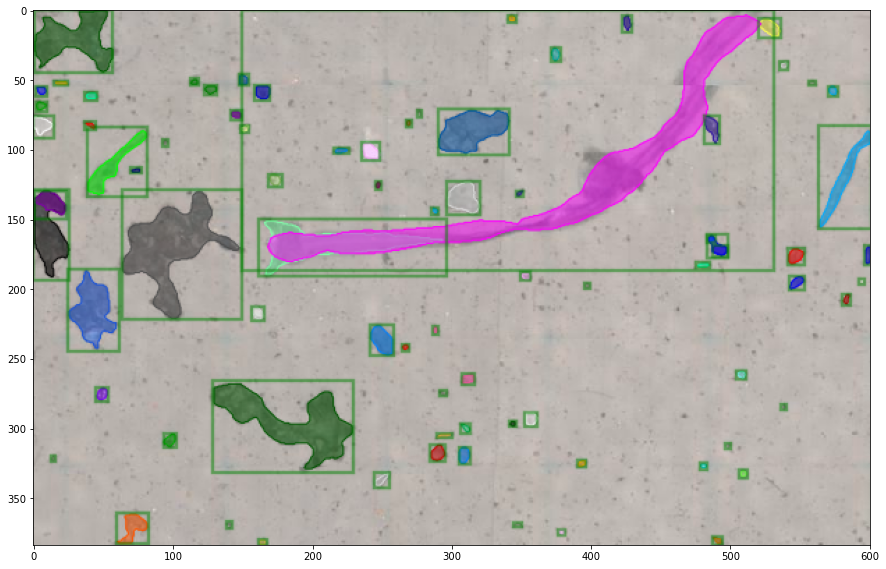

-------Annotations--------


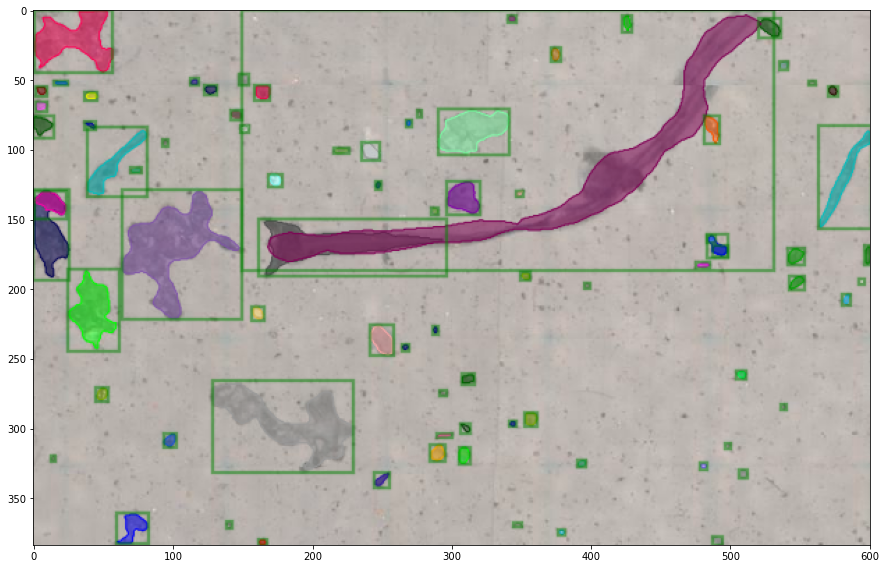

In [57]:

print("-------Predictions--------")

for d in random.sample(dataset_dicts, 1):    
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1],
                   metadata=particles_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    for m in outputs["instances"].get("pred_masks").to('cpu').numpy():
        v.draw_binary_mask(m)

    for box in outputs["instances"].pred_boxes.to('cpu'):
        v.draw_box(box)
        #v.draw_text(str(box[:2].numpy()), tuple(box[:2].numpy()))
    v = v.get_output()
    img =  v.get_image()[:, :, ::-1]
    plt.imshow(img)
    plt.show()
    
    # PLOT ANNOTATIONS
    print("-------Annotations--------")
    
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], 
                   metadata=particles_metadata, 
                   scale=0.8)
    
    #vis = v.draw_dataset_dict(d)
    
    for m in outputs["instances"].get("pred_masks").to('cpu').numpy():
        v.draw_binary_mask(m)
    for box in outputs["instances"].pred_boxes.to('cpu'):
        v.draw_box(box)
        
    v = v.get_output()
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.show()

In [46]:
tf.keras.backend.clear_session()